# Identify Artist from paintings
- Team: Bambu Paul, Creta Florin, Borodi Cristian, Mos Daniele

## Introduction

Computer analysis of visual art, especially paintings, is an interesting cross-disciplinary research domain.
With the spread of digitalization of art paintings,  research on diverse scientific approaches on painted images has become active.
The artistic style (or artistic movement) of a painting is a rich descriptor that captures both visual and historical information about the painting. 
Correctly identifying the artistic style of a paintings is crucial for indexing large artistic databases.
Our aim is to investigate the use of deep learning to solve the problem of detecting the artistic style of a painting.

## Dataset

- Dataset link [here](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)
- We are using a dataset of paintings done by about 50 artists (found on Kaggle)
- The dataset contains three files:
  - Artists.csv: dataset of information for each artist
  - Images.zip: collection of images (full size), divided in folders and sequentially numbered
  - Resized.zip: same collection but images have been resized and extracted from folder structure
- The data was scraped from artchallenge.ru during the end of February 2019.

In [32]:
from google.colab import drive
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import random
import os

In [33]:
# Mount the google drive to fetch the data 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [34]:
artists = pd.read_csv('/content/gdrive/MyDrive/Art-dataset/artists.csv')
artists.shape

(50, 8)

In [28]:
# Show artists sorted by paintings number
artists = artists.sort_values(by=['paintings'], ascending=False)
artists_top = artists[['name', 'paintings']]
artists_top.head(10)

,name,paintings
8,Vincent van Gogh,877
30,Edgar Degas,702
13,Pablo Picasso,439
15,Pierre-Auguste Renoir,336
19,Albrecht Dürer,328
46,Paul Gauguin,311
16,Francisco Goya,291
31,Rembrandt,262
20,Alfred Sisley,259
32,Titian,255


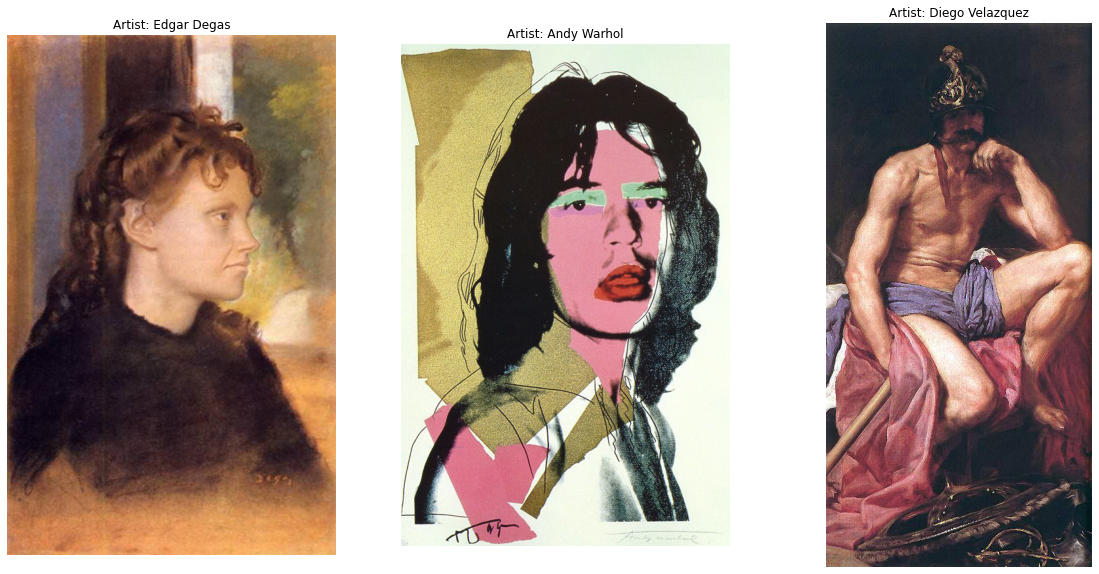

In [36]:
# See how paintings look like
fig, axes = plt.subplots(1, 3, figsize=(20,10))
images_dir = '/content/gdrive/MyDrive/Art-dataset/images/images'
artists_top_name = artists_top['name'].str.replace(' ', '_').values

for i in range(3):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()